# Libraries, Modules, and Configuration File

In [93]:
import pandas as pd
 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import CategoricalNB, GaussianNB

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from datetime import datetime
from tqdm import tqdm
import json
import copy
import hashlib

import sys
PATH = "/home/er_bim/ML-Process-Final-Project-Feb23-Bimo/"
sys.path.append(PATH)
import src.util as utils
config = utils.load_config()

# Load the Datasets

In [94]:
def load_datasets(config):

    df_train = utils.pkl_load(config['dataset_modelling_path'][0])
    x_train = df_train.drop(['card'], axis = 1)
    y_train = df_train['card']

    df_valid = utils.pkl_load(config['dataset_modelling_path'][1])
    x_valid = df_valid.drop(['card'], axis = 1)
    y_valid = df_valid['card']

    df_test = utils.pkl_load(config['dataset_modelling_path'][2])
    x_test = df_test.drop(['card'], axis = 1)
    y_test = df_test['card']

    x_train_rus = utils.pkl_load(config["dataset_train_balanced_path"][0])
    y_train_rus = utils.pkl_load(config["dataset_train_balanced_path"][1])

    x_train_ros = utils.pkl_load(config["dataset_train_balanced_path"][2])
    y_train_ros = utils.pkl_load(config["dataset_train_balanced_path"][3])

    return x_train, y_train, \
           x_valid, y_valid, \
           x_test, y_test, \
           x_train_rus, y_train_rus, \
           x_train_ros, y_train_ros

In [95]:
# Execute the function for loading datasets 

x_train, y_train, \
x_valid, y_valid, \
x_test, y_test, \
x_train_rus, y_train_rus, \
x_train_ros, y_train_ros = load_datasets(config)

## Selecting features to be trained

In [96]:
# Checking all the predictors
x_train.columns.values

array(['reports', 'age', 'owner', 'selfemp', 'dependents', 'majorcards',
       'active', 'income_log', 'expenditure_log', 'months_log', 'age_bin',
       'reports_bin', 'dependents_bin', 'active_bin'], dtype=object)

In [97]:
# Create instances for some binned features and its original value
bins = config["binned_cols"]
ori_value = config["original_cols"]

For the **baseline model**, I use the features with original value.

In [98]:
# Create the independent variables for baseline model
x_train_base = x_train.drop(bins, axis = 1)
x_train_rus_base = x_train_rus.drop(bins, axis = 1)
x_train_ros_base = x_train_ros.drop(bins, axis = 1)
x_valid_base = x_valid.drop(bins, axis = 1)
x_test_base = x_test.drop(bins, axis = 1)

For the **alternative model**, I use the binned features.

In [99]:
# Create the independent variables for alternative model
x_train_bin = x_train.drop(ori_value, axis = 1)
x_train_rus_bin = x_train_rus.drop(ori_value, axis = 1)
x_train_ros_bin = x_train_ros.drop(ori_value, axis = 1)
x_valid_bin = x_valid.drop(ori_value, axis = 1)
x_test_bin = x_test.drop(ori_value, axis = 1)

# Create Log Template

In [100]:
def time_stamp():
    return datetime.now()

In [101]:
def create_log_template():
    logger = {
        "model_name" : [],
        "model_uid" : [],
        "training_time" : [],
        "training_date" : [],
        "performance" : [],
        "accuracy" :[],
        "f1_score_avg" : [],
        "data_configurations" : [],
    }

    return logger

In [102]:
def training_log_updater(current_log, log_path):
    current_log = current_log.copy()

    try:
        with open(log_path, "r") as file:
            last_log = json.load(file)
        file.close()
    except FileNotFoundError as ffe:
        with open(log_path, "w") as file:
            file.write("[]")
        file.close()
        with open(log_path, "r") as file:
            last_log = json.load(file)
        file.close()
    
    last_log.append(current_log)

    with open(log_path, "w") as file:
        json.dump(last_log, file)
        file.close()

    return last_log

# Training and Evaluation

## Create Model Object

Create instance for each algorithm function

In [103]:
lgr      = LogisticRegression(random_state = 12)      # Logistic regression
svm      = SVC(random_state = 23)                     # Support Vector Machine 
dtc      = DecisionTreeClassifier(random_state = 34)  # Decision tree Classifier
rfc      = RandomForestClassifier(random_state = 45)  # Random Forest Classifier
knn      = KNeighborsClassifier()                     # k-Nearest Neighbors CLassifier
xgb      = XGBClassifier(random_state = 67)           # XG Boost Classifier
nb_cat   = CategoricalNB()                            # Categorical Naive Bayes Classifier
nb_gauss = GaussianNB()                               # Gaussian Naive Bayes Classifier

In [104]:
list_of_model = {
    "imbalanced" : [
        { "model_name": lgr.__class__.__name__, "model_object": lgr, "model_uid": ""},
        { "model_name": svm.__class__.__name__, "model_object": svm, "model_uid": ""},
        { "model_name": dtc.__class__.__name__, "model_object": dtc, "model_uid": ""},
        { "model_name": rfc.__class__.__name__, "model_object": rfc, "model_uid": ""},
        { "model_name": knn.__class__.__name__, "model_object": knn, "model_uid": ""},
        { "model_name": xgb.__class__.__name__, "model_object": xgb, "model_uid": ""},
        { "model_name": nb_cat.__class__.__name__, "model_object": knn, "model_uid": ""},
        { "model_name": nb_gauss.__class__.__name__, "model_object": xgb, "model_uid": ""}
        ],
    "undersampling" : [
        { "model_name": lgr.__class__.__name__, "model_object": lgr, "model_uid": ""},
        { "model_name": svm.__class__.__name__, "model_object": svm, "model_uid": ""},
        { "model_name": dtc.__class__.__name__, "model_object": dtc, "model_uid": ""},
        { "model_name": rfc.__class__.__name__, "model_object": rfc, "model_uid": ""},
        { "model_name": knn.__class__.__name__, "model_object": knn, "model_uid": ""},
        { "model_name": xgb.__class__.__name__, "model_object": xgb, "model_uid": ""},
        { "model_name": nb_cat.__class__.__name__, "model_object": knn, "model_uid": ""},
        { "model_name": nb_gauss.__class__.__name__, "model_object": xgb, "model_uid": ""}
        ],
    "oversampling" : [
        { "model_name": lgr.__class__.__name__, "model_object": lgr, "model_uid": ""},
        { "model_name": svm.__class__.__name__, "model_object": svm, "model_uid": ""},
        { "model_name": dtc.__class__.__name__, "model_object": dtc, "model_uid": ""},
        { "model_name": rfc.__class__.__name__, "model_object": rfc, "model_uid": ""},
        { "model_name": knn.__class__.__name__, "model_object": knn, "model_uid": ""},
        { "model_name": xgb.__class__.__name__, "model_object": xgb, "model_uid": ""},
        { "model_name": nb_cat.__class__.__name__, "model_object": knn, "model_uid": ""},
        { "model_name": nb_gauss.__class__.__name__, "model_object": xgb, "model_uid": ""}
        ],
    }

In [105]:
def train_eval_model(list_of_model, prefix_model_name, x_train, y_train, data_configuration_name, x_valid, y_valid, log_path):

    list_of_model = copy.deepcopy(list_of_model)
    logger = create_log_template()

    for model in tqdm(list_of_model):    
        model_name = prefix_model_name + "-" + model["model_name"]

        start_time = time_stamp()
        model["model_object"].fit(x_train, y_train)
        finished_time = time_stamp()

        elapsed_time = finished_time - start_time
        elapsed_time = elapsed_time.total_seconds()

        y_pred = model["model_object"].predict(x_valid)
        performance = classification_report(y_valid, y_pred, output_dict = True)

        plain_id = str(start_time) + str(finished_time)
        chiper_id = hashlib.md5(plain_id.encode()).hexdigest()

        model["model_uid"] = chiper_id

        logger["model_name"].append(model_name)
        logger["model_uid"].append(chiper_id)
        logger["training_time"].append(elapsed_time)
        logger["training_date"].append(str(start_time))
        logger["performance"].append(performance)
        logger["f1_score_avg"].append(performance["macro avg"]["f1-score"])
        logger["accuracy"].append(performance["accuracy"])
        logger["data_configurations"].append(data_configuration_name)

    training_log = training_log_updater(logger, log_path)

    return training_log, list_of_model

In [106]:
def training_log_to_df(training_log):
    training_res = pd.DataFrame()

    for log in tqdm(training_log):
        training_res = pd.concat([training_res, pd.DataFrame(log)])
    
    training_res.sort_values(["accuracy", "training_time"], ascending = [False, True], inplace = True)
    training_res.reset_index(inplace = True, drop = True)
    
    return training_res

## Train and Evaluate the Baseline Models

### Original (imbalanced) data

In [107]:
training_log, list_of_model_imbal = train_eval_model(
    list_of_model["imbalanced"],
    "baseline_model",
    x_train_base,
    y_train,
    "imbalanced",
    x_valid_base,
    y_valid,
    PATH+"logs/training_log_baseline.json"
)

100%|██████████| 8/8 [00:03<00:00,  2.66it/s]


In [108]:
list_of_model["imbalanced"] = copy.deepcopy(list_of_model_imbal)

### Balanced with undersampling

In [109]:
training_log, list_of_model_rus = train_eval_model(
    list_of_model["undersampling"],
    "baseline_model",
    x_train_rus_base,
    y_train_rus,
    "undersampling",
    x_valid_base,
    y_valid,
    PATH+"logs/training_log_baseline.json"
)

100%|██████████| 8/8 [00:06<00:00,  1.19it/s]


In [110]:
list_of_model["undersampling"] = copy.deepcopy(list_of_model_rus)

### Balanced with oversampling

In [111]:
training_log, list_of_model_ros = train_eval_model(
    list_of_model["oversampling"],
    "baseline_model",
    x_train_ros_base,
    y_train_ros,
    "oversampling",
    x_valid_base,
    y_valid,
    PATH+"logs/training_log_baseline.json"
)

  0%|          | 0/8 [00:00<?, ?it/s]/home/er_bim/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████| 8/8 [00:02<00:00,  3.98it/s]


In [112]:
list_of_model["oversampling"] = copy.deepcopy(list_of_model_ros)

### Table of models performance

Now let's compare the performance from each algorithm and each dataset.

In [113]:
training_res_baseline = training_log_to_df(training_log)

100%|██████████| 6/6 [00:00<00:00, 114.01it/s]


In [114]:
training_res_baseline

,model_name,model_uid,training_time,training_date,performance,accuracy,f1_score_avg,data_configurations
0,baseline_model-LogisticRegression,7148f4f68beb0656589496ca3e703d5f,0.074580,2023-05-26 14:37:31.892040,"{'0': {'precision': 0.9767441860465116, 'recal...",0.994595,0.992363,undersampling
1,baseline_model-LogisticRegression,e5f64cfd38249b50f8b22c26e60d676e,0.075665,2023-05-26 14:15:30.259355,"{'0': {'precision': 0.9767441860465116, 'recal...",0.994595,0.992363,undersampling
2,baseline_model-LogisticRegression,e2f72266853c0349abfd6078221b29a3,0.085903,2023-05-26 14:15:36.986698,"{'0': {'precision': 0.9767441860465116, 'recal...",0.994595,0.992363,oversampling
3,baseline_model-LogisticRegression,b4af5038564ab76be5683e9bdfbcdb38,0.114897,2023-05-26 14:37:27.033982,"{'0': {'precision': 0.9767441860465116, 'recal...",0.994595,0.992363,imbalanced
4,baseline_model-LogisticRegression,0f63dd0628013056faffef2bf95779f4,0.133627,2023-05-26 14:15:27.708690,"{'0': {'precision': 0.9767441860465116, 'recal...",0.994595,0.992363,imbalanced
5,baseline_model-LogisticRegression,907f5b53e89ed04a538c84c6c1fc08d5,0.191856,2023-05-26 14:37:38.971326,"{'0': {'precision': 0.9767441860465116, 'recal...",0.994595,0.992363,oversampling
6,baseline_model-GaussianNB,211cce66fc2c44af5e780c2257f9e6f4,0.249788,2023-05-26 14:15:36.506659,"{'0': {'precision': 0.9767441860465116, 'recal...",0.994595,0.992363,undersampling
7,baseline_model-GaussianNB,6610e0acaa84277b05cb64c8c0600f50,0.309802,2023-05-26 14:37:38.276802,"{'0': {'precision': 0.9767441860465116, 'recal...",0.994595,0.992363,undersampling
8,baseline_model-XGBClassifier,16dfa349765d7f4ecb0144de8ef0bbdc,0.343050,2023-05-26 14:15:28.399022,"{'0': {'precision': 0.9767441860465116, 'recal...",0.994595,0.992363,imbalanced
9,baseline_model-RandomForestClassifier,fde6f3b6316acb17dc92ff6b4d8b70c8,0.378716,2023-05-26 14:15:27.958404,"{'0': {'precision': 0.9767441860465116, 'recal...",0.994595,0.992363,imbalanced


### Interpretation



The best model that trained from the original value columns is:

In [115]:
training_res_baseline[['model_name', 'training_time', 'accuracy', 'data_configurations']].head(1)


,model_name,training_time,accuracy,data_configurations
0,baseline_model-LogisticRegression,0.07458,0.994595,undersampling


## Train and Evaluate the Alternative Models

The binned value features are used in the datasets for this model training process. 

### Original (imbalanced) data


In [116]:
training_log, list_of_model_imbal = train_eval_model(
    list_of_model["imbalanced"],
    "alternative_model",
    x_train_bin,
    y_train,
    "imbalanced",
    x_valid_bin,
    y_valid,
    PATH+"logs/training_log_alternative.json"
)
list_of_model["imbalanced"] = copy.deepcopy(list_of_model_imbal)

100%|██████████| 8/8 [00:05<00:00,  1.42it/s]


In [117]:
list_of_model["imbalanced"] = copy.deepcopy(list_of_model_imbal)


### Balanced with undersampling


In [118]:
training_log, list_of_model_rus = train_eval_model(
    list_of_model["undersampling"],
    "alternative_model",
    x_train_rus_bin,
    y_train_rus,
    "undersampling",
    x_valid_bin,
    y_valid,
    PATH+"logs/training_log_alternative.json"
)
list_of_model["undersampling"] = copy.deepcopy(list_of_model_rus)


100%|██████████| 8/8 [00:01<00:00,  5.27it/s]


### Balanced with oversampling


In [119]:
training_log, list_of_model_ros = train_eval_model(
    list_of_model["oversampling"],
    "alternative_model",
    x_train_ros_bin,
    y_train_ros,
    "oversampling",
    x_valid_bin,
    y_valid,
    PATH+"logs/training_log_alternative.json"
)
list_of_model["oversampling"] = copy.deepcopy(list_of_model_ros)

100%|██████████| 8/8 [00:01<00:00,  4.11it/s]


In [120]:
list_of_model["oversampling"] = copy.deepcopy(list_of_model_ros)


### Table of models performance

Now let's compare the performance from each algorithm and each dataset.


In [121]:
training_res_alternative = training_log_to_df(training_log)

100%|██████████| 6/6 [00:00<00:00, 267.92it/s]


In [122]:
training_res_alternative

,model_name,model_uid,training_time,training_date,performance,accuracy,f1_score_avg,data_configurations
0,alternative_model-DecisionTreeClassifier,1fc2b290ae8778ccd5a53deb092d1b2b,0.008836,2023-05-26 14:37:42.815712,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",1.000000,1.000000,imbalanced
1,alternative_model-DecisionTreeClassifier,8242bc1fedf61e92317a7f4eef6b8f88,0.009399,2023-05-26 14:15:40.739837,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",1.000000,1.000000,imbalanced
2,alternative_model-SVC,6daa46c72df2df3f8d7a90a424fa85e5,0.012841,2023-05-26 14:37:48.835455,"{'0': {'precision': 0.9767441860465116, 'recal...",0.994595,0.992363,undersampling
3,alternative_model-DecisionTreeClassifier,f75e715602f300c98da3b84ff65c0233,0.013510,2023-05-26 14:15:50.194737,"{'0': {'precision': 1.0, 'recall': 0.976190476...",0.994595,0.992234,oversampling
4,alternative_model-LogisticRegression,88659ba0212207b1811fa1f3db7fc0b0,0.020783,2023-05-26 14:37:42.722991,"{'0': {'precision': 0.9767441860465116, 'recal...",0.994595,0.992363,imbalanced
5,alternative_model-SVC,6e32702f6bd01ce5f64888f1bfb1ab8a,0.024950,2023-05-26 14:15:48.294417,"{'0': {'precision': 0.9767441860465116, 'recal...",0.994595,0.992363,undersampling
6,alternative_model-SVC,63a0daccdc339be69a626c566f05a1d0,0.031787,2023-05-26 14:15:40.690232,"{'0': {'precision': 0.9767441860465116, 'recal...",0.994595,0.992363,imbalanced
7,alternative_model-SVC,fd925c38b6bbe224e349e8bafd0a4504,0.033845,2023-05-26 14:15:50.142795,"{'0': {'precision': 0.9767441860465116, 'recal...",0.994595,0.992363,oversampling
8,alternative_model-SVC,3c1298bd9f4d42b6d6e73b8abc9bb588,0.039587,2023-05-26 14:37:42.764208,"{'0': {'precision': 0.9767441860465116, 'recal...",0.994595,0.992363,imbalanced
9,alternative_model-SVC,3cda05a055e151a2e7372e7ac852b067,0.039807,2023-05-26 14:37:50.617371,"{'0': {'precision': 0.9767441860465116, 'recal...",0.994595,0.992363,oversampling


### Interpretation

The best model that trained from the binned value columns is:

In [123]:
training_res_alternative[['model_name', 'training_time', 'accuracy', 'data_configurations']].head(1)


,model_name,training_time,accuracy,data_configurations
0,alternative_model-DecisionTreeClassifier,0.008836,1.0,imbalanced


Since the best model accuracy in the alternative models is perfect, I will not do any hyperparameter tuning.

## Best Model

The best model is produced by the original (imbalanced) data configuration, with the binned columns, and trained by Decision Tree Classifier algorithm.

In [124]:
# Create model fitting for the best model

best_model = dtc.fit(x_train_bin, y_train)


### Metrics Analysis and Evaluation

After fitting the best model, let's check the confusion matrix and classification report to analyze the model prediction. 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        42
           1       1.00      1.00      1.00       143

    accuracy                           1.00       185
   macro avg       1.00      1.00      1.00       185
weighted avg       1.00      1.00      1.00       185



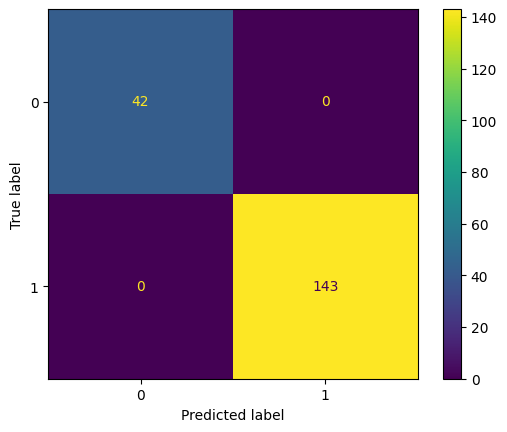

In [125]:
# Run the model on the validation data

y_pred = best_model.predict(x_valid_bin)

report_on_valid = classification_report(y_valid, y_pred, output_dict = True)

ConfusionMatrixDisplay.from_predictions(y_valid, y_pred)
print(classification_report(y_valid, y_pred))


              precision    recall  f1-score   support

           0       0.91      0.96      0.93        50
           1       0.99      0.97      0.98       174

    accuracy                           0.97       224
   macro avg       0.95      0.97      0.96       224
weighted avg       0.97      0.97      0.97       224



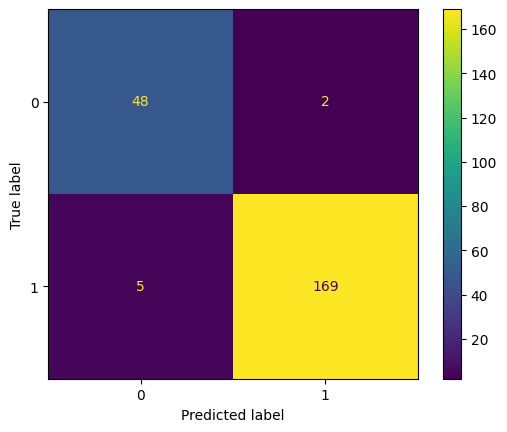

In [126]:
# Run the model on the test data

y_pred = best_model.predict(x_test_bin)

report_on_test = classification_report(y_test, y_pred, output_dict = True)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
print(classification_report(y_test, y_pred))

In [127]:
acc_on_valid = report_on_valid["accuracy"]
acc_on_valid

acc_on_test = report_on_test["accuracy"]
acc_on_test

print(f"The accuracy score difference between testing and validation datasets is: {round(acc_on_test - acc_on_valid, 6)}")

The accuracy score difference between testing and validation datasets is: -0.03125


In credit card approval prediction, it is crucial to predict correctly the **accuracy score**, which means the machine learning model is able to predict the approval status of the applications as approved that originally got approved, and vice versa.

If the defect in credit card approval prediction can be kept at a very low level, the credit card issuer will not have a problem handling the credit default status.

## Conclusion

In credit card approval prediction, it is crucial to predict correctly the **accuracy score**, which means the machine learning model can predict the approval status of the applications as approved that originally got approved, and vice versa.


If the defect in credit card approval prediction can be kept at a very low level, the credit card issuer will not have a problem handling the credit default status.

In this problem, the original dataset configuration which has an imbalance result on the target column works better to predict the new data, with perfect accuracy, 100%.

The binned values on several features also made the model smoother to learn from the predictors than the original value on the same features which made the data distribution wider.

In [128]:
# Save the best model
utils.pkl_dump(best_model, config["production_model_path"])
best_model


DecisionTreeClassifier(random_state=34)